In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import geoplot
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
import xgboost as xgb

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

In [2]:
data = pd.read_csv("../../data/clean_survey_data/2019_clean.csv", low_memory=False)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446 entries, 0 to 445
Columns: 212 entries, id to cfvo_30-60cm_mean
dtypes: float64(160), int64(47), object(5)
memory usage: 738.8+ KB


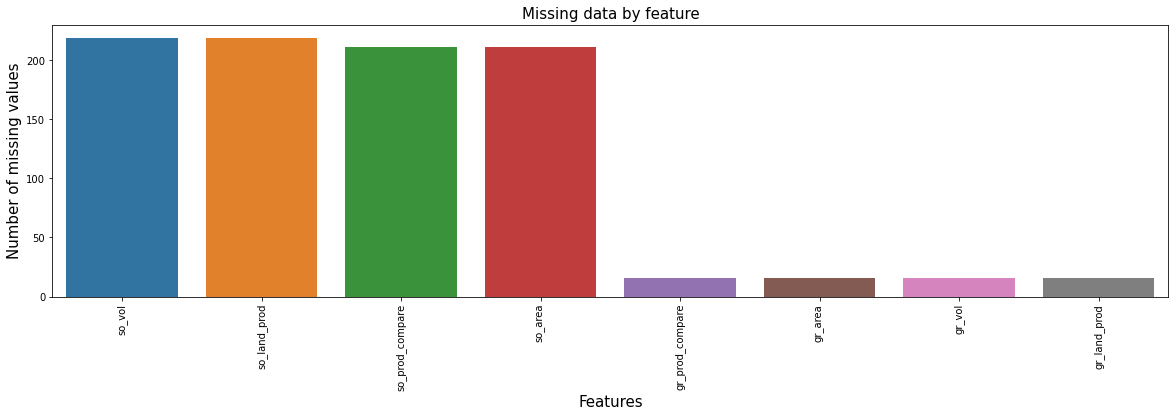

In [4]:
# find all missing values along with their datatype
total = data.isnull().sum().to_dict()
missingValues = {}
for col in total: 
    if total[col] != 0:
        missingValues[col] = {}
        missingValues[col]['amount'] = total[col]
        missingValues[col]['share'] = round(total[col] / len(data[col]), 2)
        missingValues[col]['type'] = data.dtypes[col]
        
missingValues = pd.DataFrame.from_dict(missingValues, orient='index').sort_values(by='share', ascending=False)

# visualize missing values
f, ax = plt.subplots(figsize=(20, 5))
plt.xticks(rotation='90')
sns.barplot(x=missingValues.index, y=missingValues['amount'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Number of missing values', fontsize=15)
plt.title('Missing data by feature', fontsize=15)
plt.show()

In [5]:
#df = pd.read_csv("../../data/GIZ_input_files/answers/GIC Zambia_Data_HH_EP_ 2019.csv", low_memory=False)

In [6]:
# split into two separate datasets
soy = data[data["soybeans"] == 1]
soy = soy[soy.columns.drop(list(soy.filter(regex="gr_.*")))]
nuts = data[data["groundnuts"] == 1]
nuts = nuts[nuts.columns.drop(list(nuts.filter(regex="so_.*")))]

Text(0.5, 0, 'Land productivity for groundnuts in kg/ha')

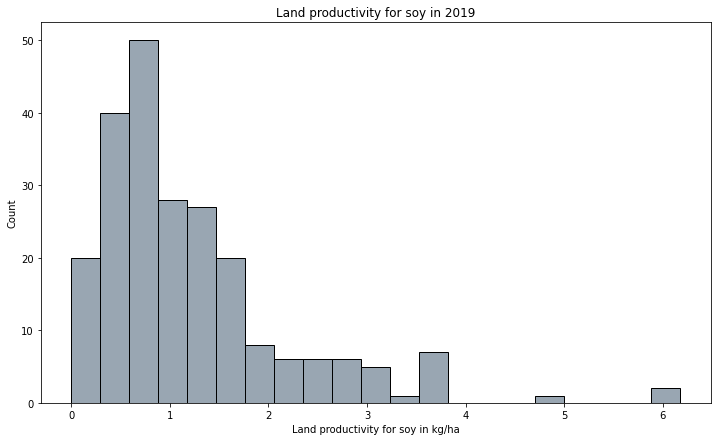

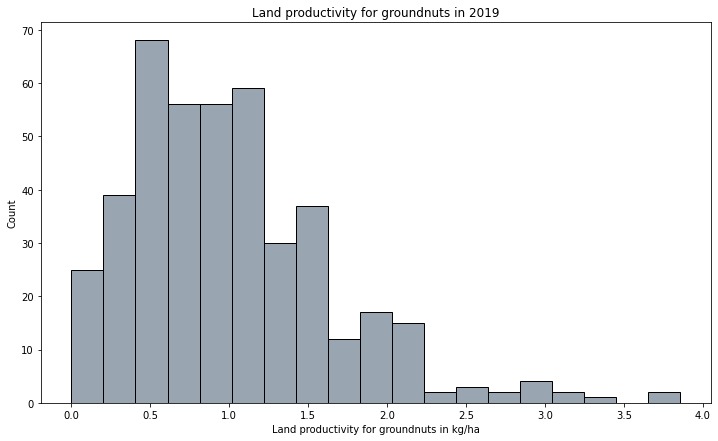

In [7]:
# Visualize yield with outliers
fig = plt.figure(figsize=(12,7))
sns.histplot(soy["so_land_prod"], color="lightslategray")
plt.title("Land productivity for soy in 2019")
plt.xlabel("Land productivity for soy in tons/hectare")
#plt.savefig("../../figures/Histograms/soy_without_outliers.png")

# Visualize yield with outliers
fig = plt.figure(figsize=(12,7))
sns.histplot(nuts["gr_land_prod"], color="lightslategray")
plt.title("Land productivity for groundnuts in 2019")
plt.xlabel("Land productivity for groundnuts in tons/hectare")
#plt.savefig("../../figures/Histograms/groundnuts_without_outliers.png")

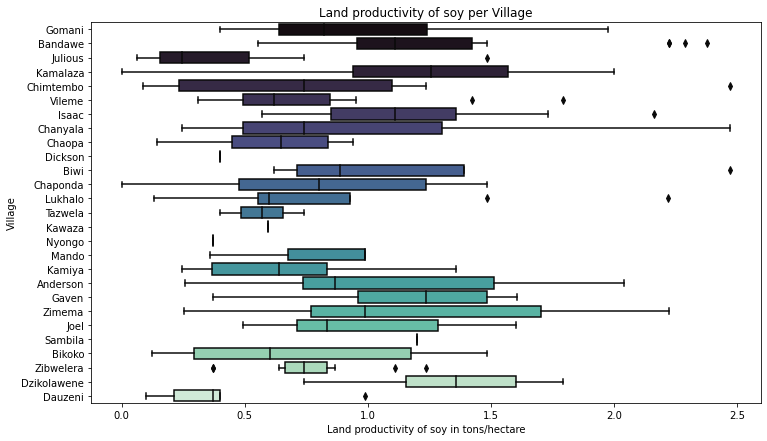

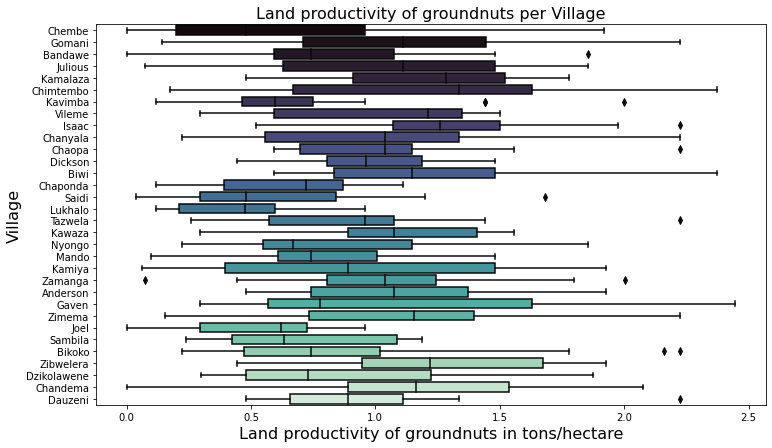

In [13]:
# Yield per village
fig = plt.figure(figsize=(12,7))
sns.boxplot(data=soy, x="so_land_prod", y="village", palette="mako",
            order=soy[["village", "gps_lat"]].groupby("village").min().sort_values(by="gps_lat", ascending=False).index.to_list())
plt.title("Land productivity of soy per Village")
plt.xlabel("Land productivity of soy in tons/hectare")
plt.ylabel("Village")
#plt.savefig("../../figures/Histograms/soy_without_outliers_boyplot.png")

# Yield per village
fig = plt.figure(figsize=(12,7))
sns.boxplot(data=nuts, x="gr_land_prod", y="village", palette="mako",
            order=nuts[["village", "gps_lat"]].groupby("village").min().sort_values(by="gps_lat", ascending=False).index.to_list())
plt.title("Land productivity of groundnuts per Village", fontsize=16)
plt.xlabel("Land productivity of groundnuts in tons/hectare", fontsize=16)
plt.ylabel("Village", fontsize=16)
#plt.savefig("../../figures/Histograms/groundnuts_without_outliers_boyplot.png")

Text(0, 0.5, '')

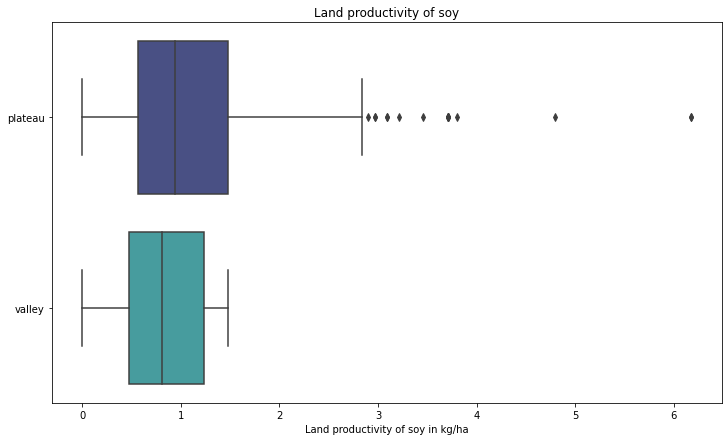

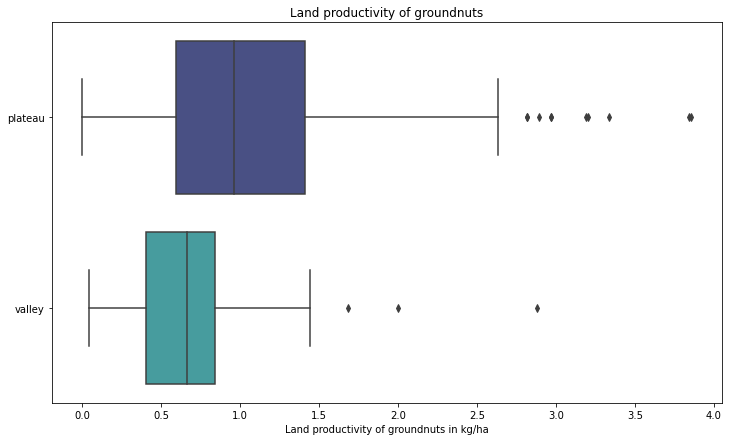

In [9]:
# Yield plateau / valley
fig = plt.figure(figsize=(12,7))
sns.boxplot(data=soy, x="so_land_prod", y="plateau_or_valley", palette="mako")
plt.title("Land productivity of soy")
plt.xlabel("Land productivity of soy in tons/hectare")
plt.ylabel("")
#plt.savefig("../../figures/Histograms/soy_with_outliers_boyplot_plv.png")

# Yield plateau / valley
fig = plt.figure(figsize=(12,7))
sns.boxplot(data=nuts, x="gr_land_prod", y="plateau_or_valley", palette="mako")
plt.title("Land productivity of groundnuts")
plt.xlabel("Land productivity of groundnuts in tons/hectare")
plt.ylabel("")
#plt.savefig("../../figures/Histograms/groundnuts_with_outliers_boyplot_plv.png")

In [9]:
# Remove outliers separately
cnt_0 = soy.shape[0]
soy = soy.loc[soy["so_land_prod"] <= 2.5]
cnt_1 = soy.shape[0]
print(f"Removed {cnt_0-cnt_1} observations due to unrealistic yield value for soy.\nNumber of observations left: {cnt_1}")
cnt_0 = nuts.shape[0]
nuts = nuts.loc[nuts["gr_land_prod"] <= 2.5]
cnt_1 = nuts.shape[0]
print(f"Removed {cnt_0-cnt_1} observations due to unrealistic yield value for groundnuts.\nNumber of observations left: {cnt_1}")

Removed 32 observations due to unrealistic yield value for soy.
Number of observations left: 203
Removed 13 observations due to unrealistic yield value for groundnuts.
Number of observations left: 417


In [11]:
# data types of all columns -> used to filter 
nuts_types = {} 
for col in nuts.columns:
    nuts_types[col] = {}
    nuts_types[col]["type"] = nuts.dtypes[col]
    if len(nuts[col].unique()) <= 2:
        nuts_types[col]["binary"] = 1
    else:
        nuts_types[col]["binary"] = 0
nuts_types = pd.DataFrame.from_dict(nuts_types, orient='index')
# numerical columns -> used to detect outliers
nuts_num_cols = nuts_types.loc[~(nuts_types["type"] == "object") & (nuts_types["binary"] == 0)].index.to_list()
# binary cols
nuts_bin_cols = nuts_types.loc[nuts_types["binary"] == 1].index.to_list()

In [19]:
nuts[nuts["gr_prod_compare"] >= 5].groupby("gr_prod_compare").sum()
# 'gr_prod_compare_rainfall_excess',
# 'gr_prod_compare_rainfall_shortage',
# 'gr_prod_compare_rainfall_pattern',

groundnuts  soybeans  radio_comaco  gr_chemical  gr_manure  \
gr_prod_compare                                                               
5.0                      69        40            47          1.0        5.0   
6.0                     134        65           103          0.0        8.0   

                 gr_insecticides  gr_herbicides  gr_fungicides  \
gr_prod_compare                                                  
5.0                          0.0            2.0            0.0   
6.0                          2.0            0.0            0.0   

                 land_how_purchased  land_how_rented  land_how_inherited  \
gr_prod_compare                                                            
5.0                               0                7                  61   
6.0                               2               11                 113   

                 land_how_received  land_how_acquired  nr_field  \
gr_prod_compare                                                   
5.0                              4                  6       180   
6.0                             16                  7       393   

                 radio_dev_phone  radio_dev_smartphone  radio_dev_tablet  \
gr_prod_compare                                                            
5.0                           53                     0                 0   
6.0                           92                     5                 0   

                 radio_dev_radio  radio_dev_other  radio_dev_none  radio_time  \
gr_prod_compare                                                                 
5.0                           32                0              10        66.0   
6.0                           72                0              23       161.0   

                 radio_group_family  radio_group_neighbor  \
gr_prod_compare                                             
5.0                            34.0                   5.0   
6.0                            78.0                  15.0   

                 radio_group_producer  radio_group_cooperative  \
gr_prod_compare                                                  
5.0                               8.0                      2.0   
6.0                              17.0                      7.0   

                 radio_group_other  train_frequency  train_hinder_1  \
gr_prod_compare                                                       
5.0                            6.0              230            16.0   
6.0                            5.0              386            27.0   

                 train_hinder_9  train_hinder_2  train_hinder_3  \
gr_prod_compare                                                   
5.0                         5.0             1.0             9.0   
6.0                        27.0             4.0            12.0   

                 train_hinder_4  train_hinder_5  train_hinder_6  \
gr_prod_compare                                                   
5.0                         0.0             0.0             3.0   
6.0                         0.0             2.0             2.0   

                 train_hinder_7  train_hinder_8  train_hinder_97  \
gr_prod_compare                                                    
5.0                         0.0             6.0              2.0   
6.0                         0.0             7.0              8.0   

                 gr_prod_compare_rainfall_excess  \
gr_prod_compare                                    
5.0                                         18.0   
6.0                                         29.0   

                 gr_prod_compare_rainfall_shortage  \
gr_prod_compare                                      
5.0                                           18.0   
6.0                                           44.0   

                 gr_prod_compare_rainfall_pattern  \
gr_prod_compare                                     
5.0                                          22.0   
6.0                                     

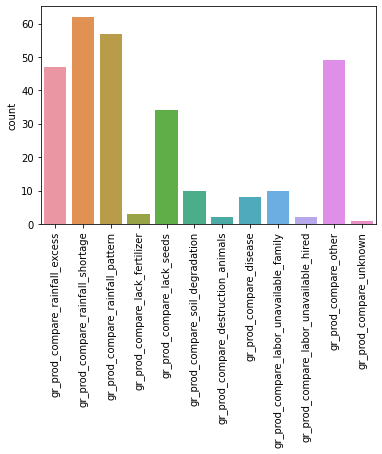

In [89]:
# Rainfall is one of the main rasons for decreased productivity
compare = ["gr_prod_compare_rainfall_excess", "gr_prod_compare_rainfall_shortage", "gr_prod_compare_rainfall_pattern",
           "gr_prod_compare_lack_fertilizer", "gr_prod_compare_lack_seeds", "gr_prod_compare_soil_degradation",
           "gr_prod_compare_destruction_animals", "gr_prod_compare_disease",
           "gr_prod_compare_labor_unavailable_family", "gr_prod_compare_labor_unavailable_hired",
           "gr_prod_compare_other", "gr_prod_compare_unknown"]
compare_reasons = pd.DataFrame(nuts[nuts["gr_prod_compare"] >= 5][compare].sum(), columns=["count"])
sns.barplot(data=compare_reasons, x=compare_reasons.index, y="count")
plt.xticks(rotation=90)
plt.show()

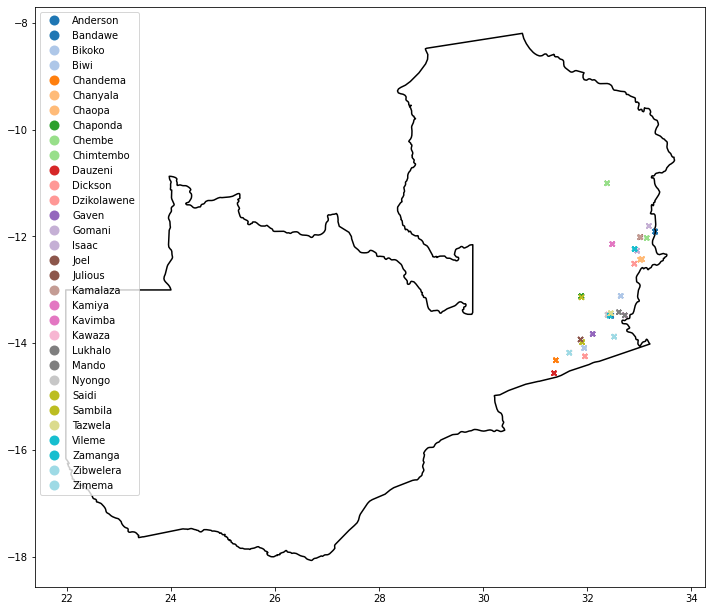

In [208]:
import geopandas

nuts_lower = nuts[nuts["gr_prod_compare"] >= 5]
nuts_higher = nuts[nuts["gr_prod_compare"] < 5]

fig, ax = plt.subplots(figsize=(12,12))
world = gpd.read_file('../../data/geodata/countries.geojson').to_crs('EPSG:4326')
zambia = world[world.ADMIN == 'Zambia'].geometry.boundary.plot(color=None, edgecolor='black', ax=ax)
gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(nuts["gps_lon"], nuts["gps_lat"]),
                        crs='epsg:4326')
gdf.plot(column=nuts["village"], ax=ax, marker="x", markersize=20, legend=True, cmap="tab20")
plt.show()

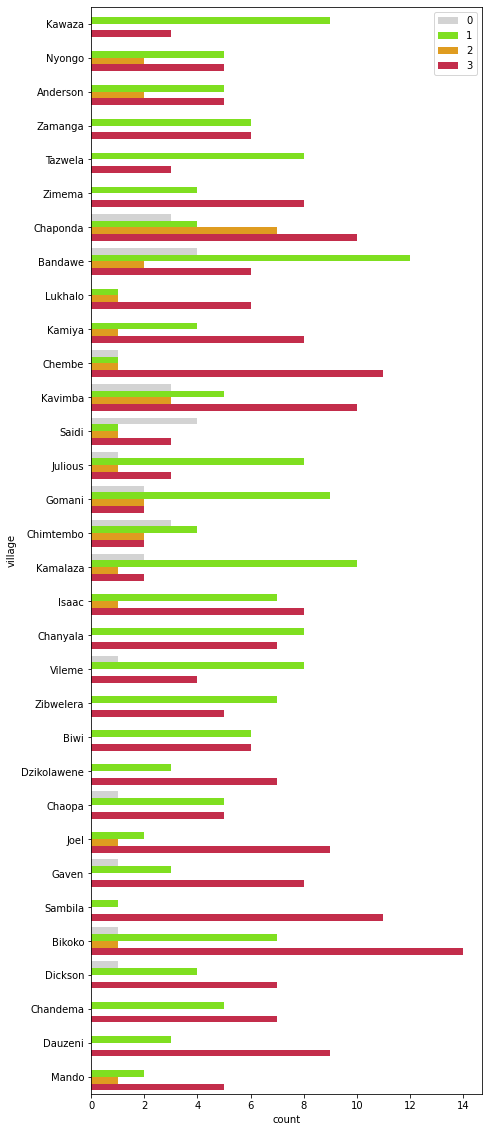

In [133]:
# aggregate into larger groups
# 0: did not grow 1: better 2: same 3: worse
nuts["gr_prod_compare_agg"] = nuts.apply(lambda row: 0 if row.gr_prod_compare == 1 else
                                         1 if row.gr_prod_compare in (2,3) else
                                        2 if row.gr_prod_compare == 4 else
                                        3, axis=1)
# color map
colormap = {
    0: "lightgray",
    1: "chartreuse",
    2: "orange",
    3: "crimson"
}
# in one GPS location (Village), do all farms have the same answer regarding the rainfall pattern?
fig, ax = plt.subplots(figsize=(7,20))
sns.countplot(data=nuts, hue="gr_prod_compare_agg", y="village", palette=colormap)
plt.legend(loc="upper right")
plt.show()


# even within one city, there are farms in which the production was better and farms in which it was worse
# e.g. Gaven, Dickson
# might still be due to non-weather related variables, such as availability of labor

#nuts[nuts["village"] == "Dickson"]

# groundnuts is column of ones -> used to count
# encode worse / better / normal to count
nuts["gr_prod_compare_worse"] = nuts.apply(lambda row: 1 if row.gr_prod_compare in (5,6) else 0, axis=1)
nuts["gr_prod_compare_better"] = nuts.apply(lambda row: 1 if row.gr_prod_compare in (2,3) else 0, axis=1)
nuts["gr_prod_compare_normal"] = nuts.apply(lambda row: 1 if row.gr_prod_compare == 4 else 0, axis=1)

gr_prod_compare_reasons_village = nuts.groupby("village").sum()[compare + ["groundnuts",
                                                                           "gr_prod_compare_worse",
                                                                           "gr_prod_compare_better",
                                                                           "gr_prod_compare_normal"]]

#sns.barplot(data=gr_prod_compare_reasons_village, x=gr_prod_compare_reasons_village.index, y=)

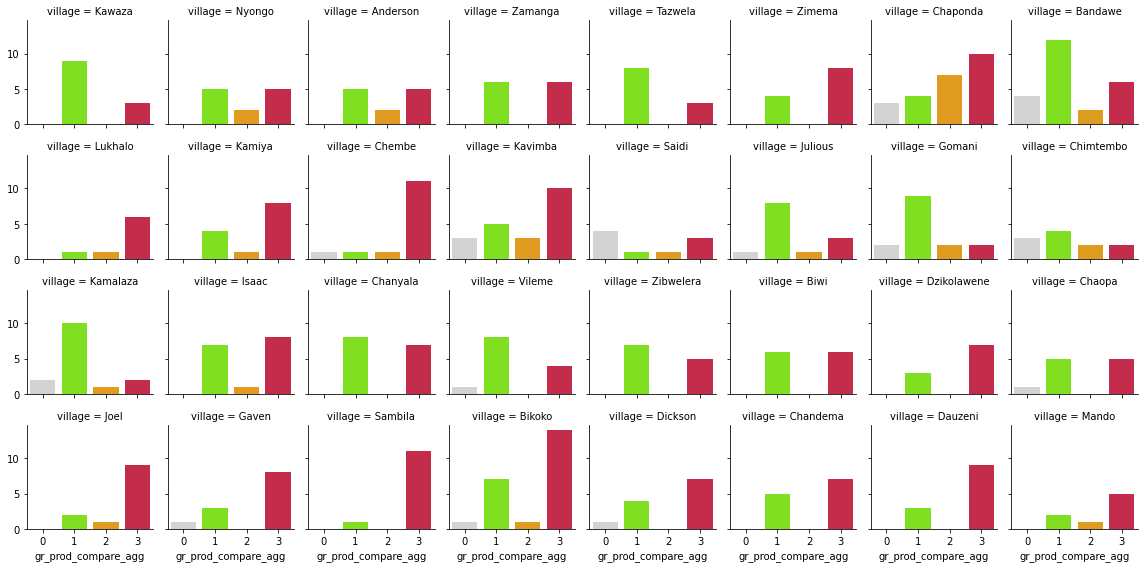

In [145]:
# Is there a trend visible? (=Within one village, was the production better or worse?)
g = sns.FacetGrid(nuts, col="village", col_wrap=8, height=2)
g.map(sns.countplot, "gr_prod_compare_agg", palette=colormap, order=[0,1,2,3])

Text(0.5, 0.98, 'Complaints about rainfall:\n -1: Rain Shortage, 1: Rain Excess 0: Rain Pattern 2: No complaints')

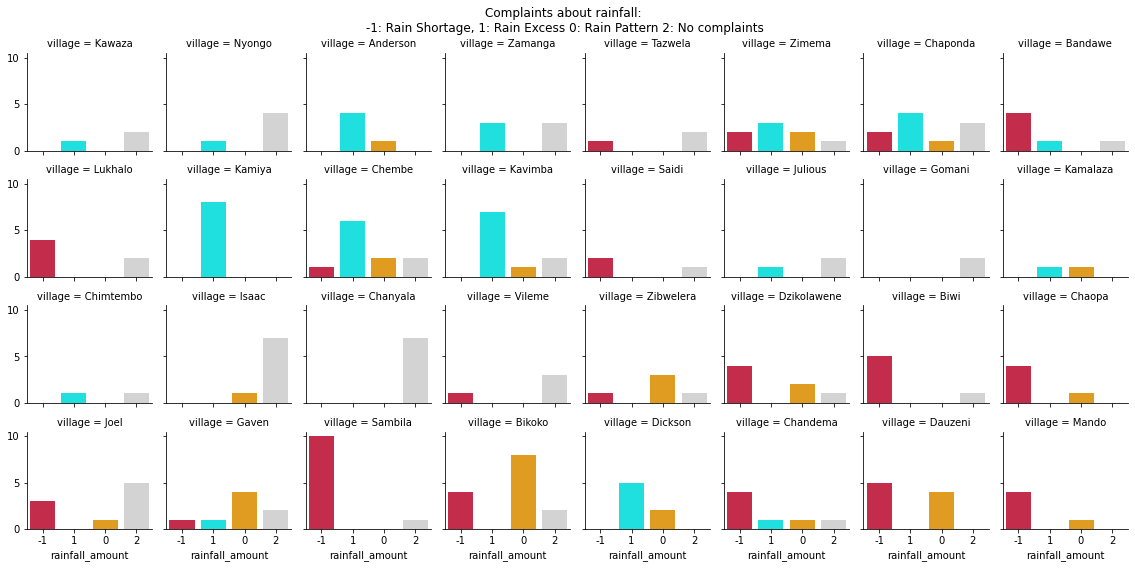

In [197]:
# check whether one farm claims both shortage and excess -> Nope
len(nuts.loc[nuts["gr_prod_compare_rainfall_shortage"] + nuts["gr_prod_compare_rainfall_excess"] == 2])
# thus, we can put them together in one variable
nuts["rainfall_amount"] = nuts.apply(lambda row: 1 if row.gr_prod_compare_rainfall_excess == 1 else
                                     -1 if row.gr_prod_compare_rainfall_shortage == 1 else
                                     0 if row.gr_prod_compare_rainfall_pattern == 1 else
                                     2, axis=1)
colormap = {
    2: "lightgray",
    0: "orange",
    1: "aqua",
    -1: "crimson"
}

# plot how many famers complain about rainfall (shortage / excess) per village
g = sns.FacetGrid(nuts[nuts["gr_prod_compare"] >= 5], col="village", col_wrap=8, height=2)
g.map(sns.countplot, "rainfall_amount", order=[-1,1,0,2], palette=colormap)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Complaints about rainfall:\n -1: Rain Shortage, 1: Rain Excess 0: Rain Pattern 2: No complaints")
# conclusion:
# rain excess: Anderson, Zamanga, Kamiya, Chembe, Kavimba, Julios, Kamalaza, Chimtembo, Dickson
# rain shortage: Tazwela, Bandawe, Lukhalo, Saidi, Dzikolawene, Biwi, Chaopa, Joel,
#                Sambila, Bikoko, Chandema, Dauzeni, Mando

In [176]:
a

gr_prod_compare_rainfall_excess  \
village                                        
Anderson                                 4.0   
Bandawe                                  1.0   
Bikoko                                   0.0   
Biwi                                     0.0   
Chandema                                 1.0   
Chanyala                                 0.0   
Chaopa                                   0.0   
Chaponda                                 4.0   
Chembe                                   6.0   
Chimtembo                                1.0   
Dauzeni                                  0.0   
Dickson                                  5.0   
Dzikolawene                              0.0   
Gaven                                    1.0   
Gomani                                   0.0   
Isaac                                    0.0   
Joel                                     0.0   
Julious                                  1.0   
Kamalaza                                 1.0   
Kamiya                                   8.0   
Kavimba                                  7.0   
Kawaza                                   1.0   
Lukhalo                                  0.0   
Mando                                    0.0   
Nyongo                                   1.0   
Saidi                                    0.0   
Sambila                                  0.0   
Tazwela                                  0.0   
Vileme                                   0.0   
Zamanga                                  3.0   
Zibwelera                                0.0   
Zimema                                   3.0   

             gr_prod_compare_rainfall_shortage  \
village                                          
Anderson                                   0.0   
Bandawe                                    4.0   
Bikoko                                     4.0   
Biwi                                       5.0   
Chandema                                   4.0   
Chanyala                                   0.0   
Chaopa                                     4.0   
Chaponda                                   2.0   
Chembe                                     1.0   
Chimtembo                                  0.0   
Dauzeni                                    5.0   
Dickson                                    0.0   
Dzikolawene                                4.0   
Gaven                                      1.0   
Gomani                                     0.0   
Isaac                                      0.0   
Joel                                       3.0   
Julious                                    0.0   
Kamalaza                                   0.0   
Kamiya                                     0.0   
Kavimba                                    0.0   
Kawaza                                     0.0   
Lukhalo                                    4.0   
Mando                                      4.0   
Nyongo                                     0.0   
Saidi                                      2.0   
Sambila                                   10.0   
Tazwela                                    1.0   
Vileme                                     1.0   
Zamanga                                    0.0   
Zibwelera                                  1.0   
Zimema                                     2.0   

             gr_prod_compare_rainfall_pattern  groundnuts  
village                                                    
Anderson                                  1.0          12  
Bandawe                                   0.0          24  
Bikoko                                    8.0          23  
Biwi                                      2.0          12  
Chandema                                  6.0          12  
Chanyala                                  0.0          15  
Chaopa                                    5.0          11  
Chaponda                                  1.0          24  
Chembe                                    2.0          14  
Chimtembo          

<AxesSubplot:xlabel='gr_prod_compare', ylabel='gr_land_prod'>

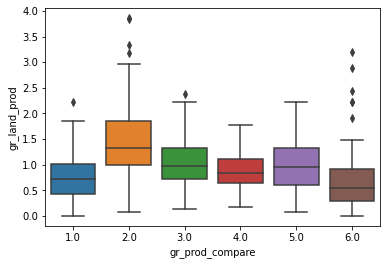

In [102]:
sns.boxplot(data=nuts, x="gr_prod_compare", y="gr_land_prod")

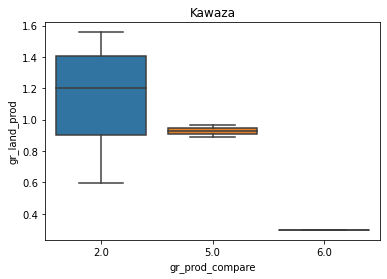

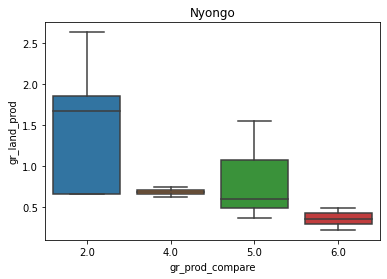

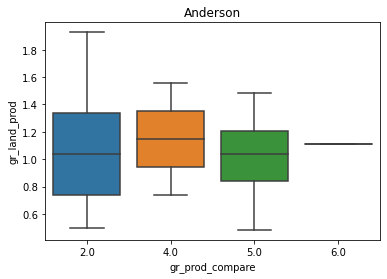

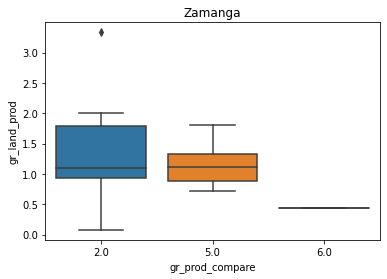

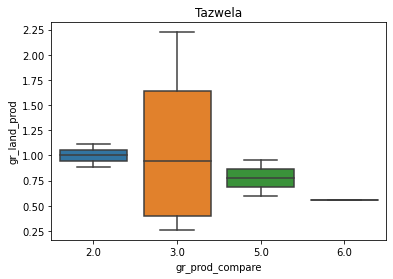

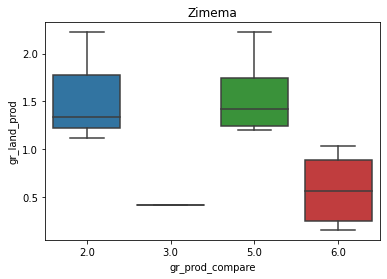

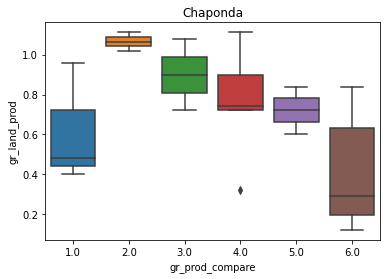

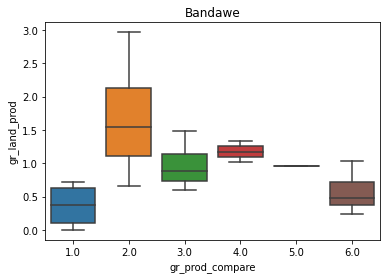

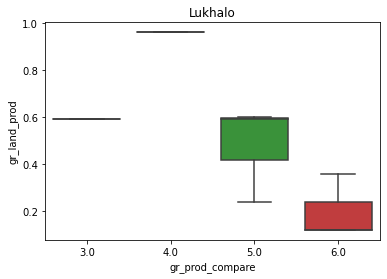

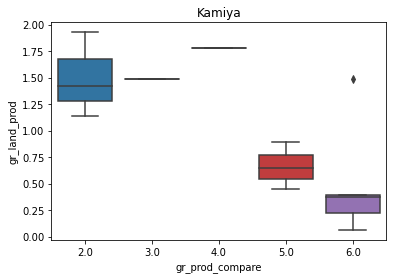

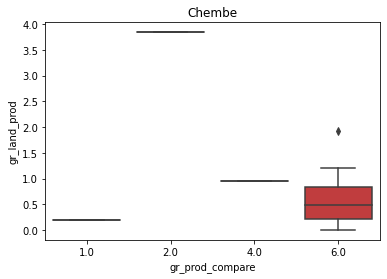

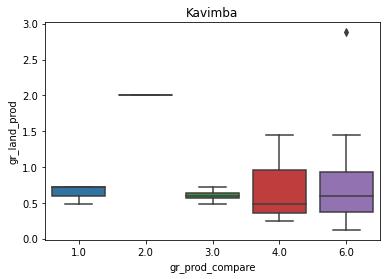

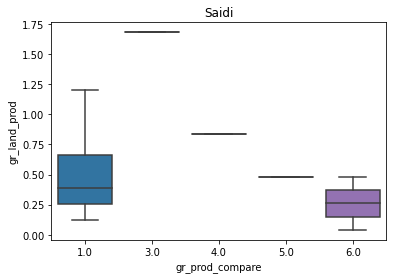

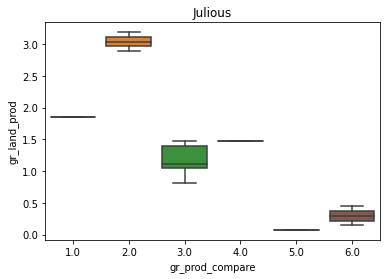

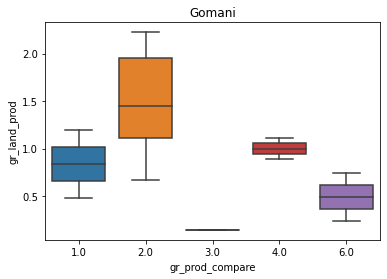

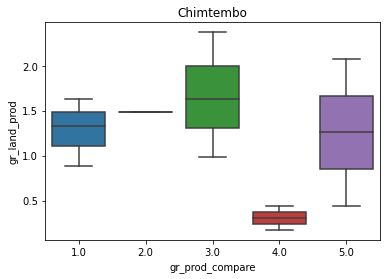

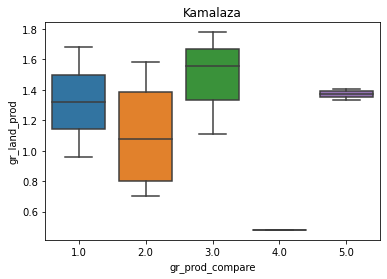

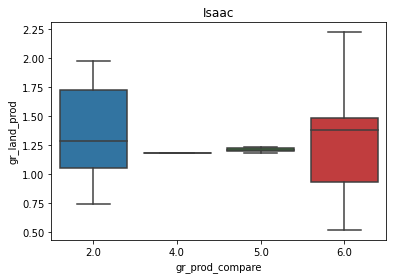

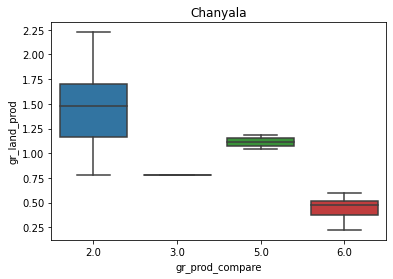

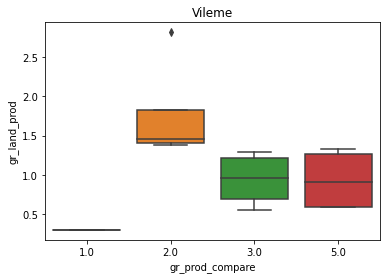

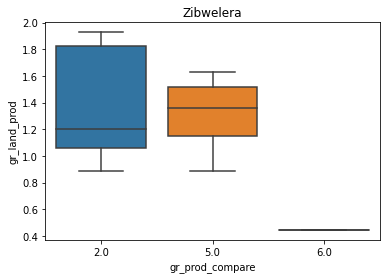

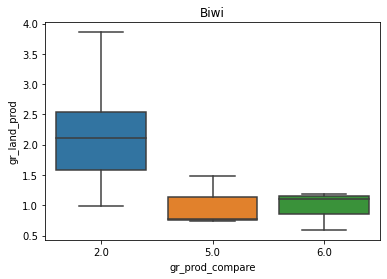

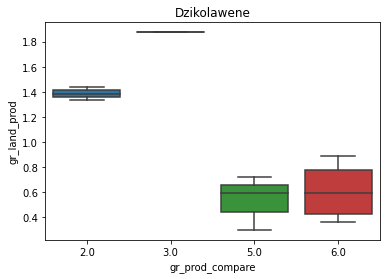

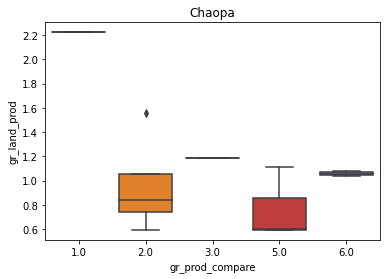

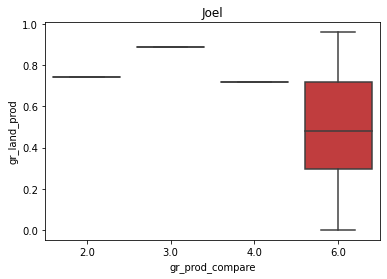

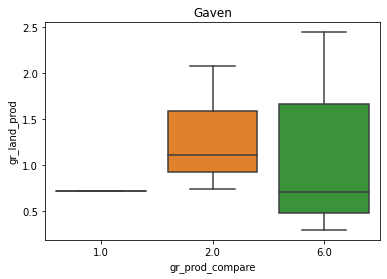

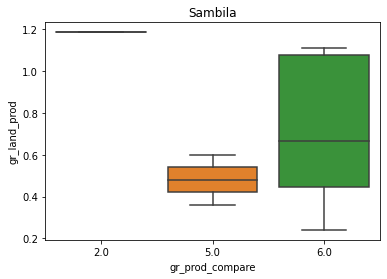

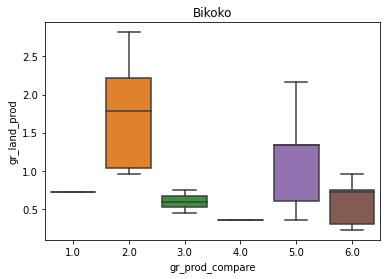

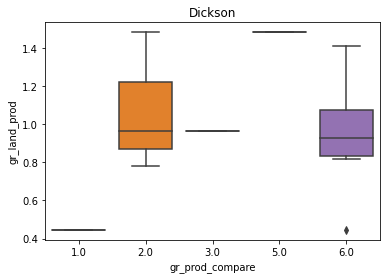

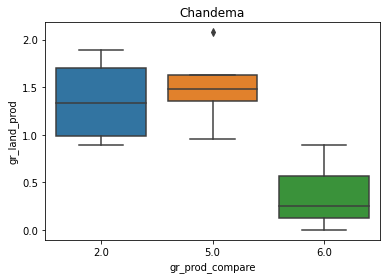

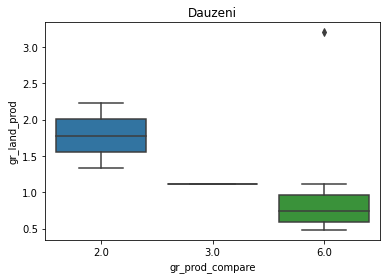

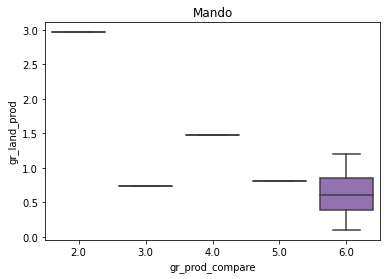

In [123]:
villages = nuts.village.unique()
for village in villages:
    sns.boxplot(data=nuts[nuts["village"] == village], x="gr_prod_compare", y="gr_land_prod")
    plt.title(village)
    plt.show()

In [57]:
#nuts[compare].groupby("gps_lat").sum().sort_values(by="gr_prod_compare_rainfall_excess")

gr_prod_compare_rainfall_excess  \
gps_lat                                       
-14.561780                              0.0   
-12.234696                              0.0   
-12.266040                              0.0   
-12.423373                              0.0   
-12.435000                              0.0   
-13.112352                              0.0   
-13.140837                              0.0   
-13.418667                              0.0   
-11.802963                              0.0   
-13.476752                              0.0   
-13.438050                              0.0   
-14.089948                              0.0   
-14.245790                              0.0   
-14.176977                              0.0   
-13.929558                              0.0   
-13.981275                              0.0   
-13.460853                              1.0   
-12.013970                              1.0   
-13.468312                              1.0   
-14.319623                              1.0   
-11.907561                              1.0   
-12.028928                              1.0   
-13.825722                              1.0   
-12.012612                              1.0   
-13.876242                              3.0   
-13.481555                              3.0   
-13.118682                              4.0   
-13.484183                              4.0   
-12.509130                              5.0   
-11.002890                              6.0   
-12.142894                              6.0   
-13.477292                              8.0   

            gr_prod_compare_rainfall_shortage  \
gps_lat                                         
-14.561780                                5.0   
-12.234696                                1.0   
-12.266040                                0.0   
-12.423373                                0.0   
-12.435000                                4.0   
-13.112352                                5.0   
-13.140837                                2.0   
-13.418667                                4.0   
-11.802963                                0.0   
-13.476752                                4.0   
-13.438050                                1.0   
-14.089948                                4.0   
-14.245790                                4.0   
-14.176977                                1.0   
-13.929558                                3.0   
-13.981275                               10.0   
-13.460853                                0.0   
-12.013970                                0.0   
-13.468312                                0.0   
-14.319623                                4.0   
-11.907561                                4.0   
-12.028928                                0.0   
-13.825722                                1.0   
-12.012612                                0.0   
-13.876242                                2.0   
-13.481555                                0.0   
-13.118682                                2.0   
-13.484183                                0.0   
-12.509130                                0.0   
-11.002890                                1.0   
-12.142894                                0.0   
-13.477292                                0.0   

            gr_prod_compare_rainfall_pattern  gr_prod_compare_lack_fertilizer  \
gps_lat                                                                         
-14.561780                               5.0                              0.0   
-12.234696                               0.0                              0.0   
-12.266040                               1.0                              0.0   
-12.423373                               0.0                              0.0   
-12.435000                               5.0                              0.0   
-13.112352                               2.0                              0.0   
-13.140837                               0.0                              0.0   
-13.418667       

In [64]:
(nuts["gr_prod_compare_rainfall_shortage"] + nuts["gr_prod_compare_rainfall_excess"] == 2 ).sum()

0

In [70]:
nuts["train_hinder_total"] = nuts.apply(lambda row:
                                        row.train_hinder_1 +
                                        row.train_hinder_2 +
                                        row.train_hinder_3 + 
                                        row.train_hinder_4 + 
                                        row.train_hinder_5 +
                                        row.train_hinder_6 + 
                                        row.train_hinder_7 +
                                        row.train_hinder_8 + 
                                        row.train_hinder_9, axis=1)
sns.histplot(nuts["train_hinder_total"])

In [97]:
nuts.groupby("train_frequency").sum()

groundnuts  soybeans  radio_comaco  gr_chemical  gr_manure  \
train_frequency                                                               
1                       107        57            92          0.0       13.0   
2                        89        51            64          1.0        5.0   
3                        47        24            36          0.0        3.0   
4                        19        12            11          0.0        2.0   
5                        75        35            39          0.0        5.0   
6                        80        34            40          0.0        0.0   

                 gr_insecticides  gr_herbicides  gr_fungicides  \
train_frequency                                                  
1                            2.0            1.0            0.0   
2                            1.0            3.0            0.0   
3                            1.0            2.0            0.0   
4                            1.0            0.0            0.0   
5                            0.0            1.0            0.0   
6                            0.0            1.0            0.0   

                 land_how_purchased  land_how_rented  land_how_inherited  \
train_frequency                                                            
1                                 0                4                  88   
2                                 1                5                  76   
3                                 2                2                  41   
4                                 0                1                  17   
5                                 0                6                  70   
6                                 2               10                  76   

                 land_how_received  land_how_acquired  nr_field  \
train_frequency                                                   
1                                6                 14       299   
2                                9                  9       243   
3                                5                  3       127   
4                                3                  0        54   
5                                5                  1       179   
6                                1                  2       213   

                 radio_dev_phone  radio_dev_smartphone  radio_dev_tablet  \
train_frequency                                                            
1                             75                     2                 0   
2                             61                     2                 0   
3                             37                     1                 0   
4                             12                     0                 0   
5                             50                     3                 0   
6                             60                     3                 0   

                 radio_dev_radio  radio_dev_other  radio_dev_none  radio_time  \
train_frequency                                                                 
1                             60                0              16       125.0   
2                             44                1              12        97.0   
3                             25                0               3        53.0   
4                              6                0               6        21.0   
5                             30                1              17        48.0   
6                             30                0              16        87.0   

                 radio_group_family  radio_group_neighbor  \
train_frequency                                             
1                              63.0                   9.0   
2                              51.0                   9.0   
3                              30.0                   6.0   
4                              11.0                   1.0   
5                              29.0                   3.0   
6                       

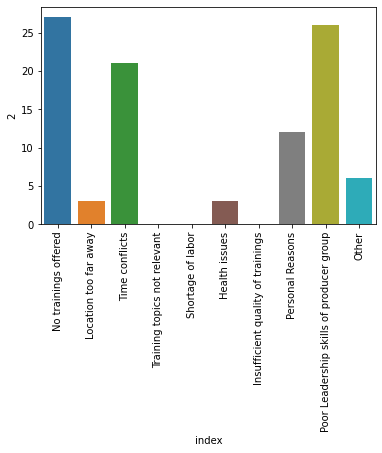

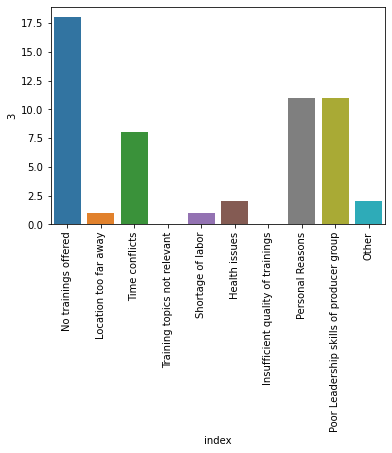

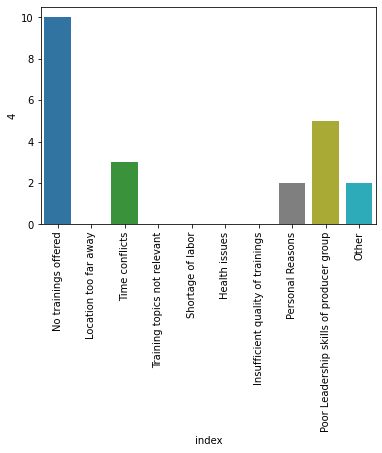

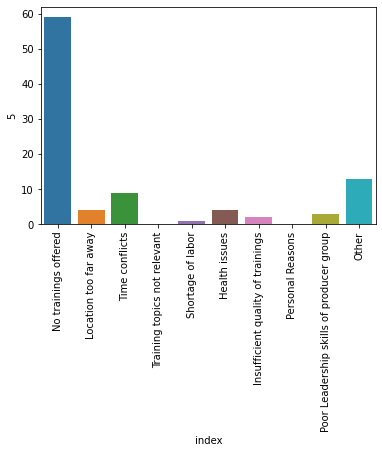

In [141]:
train_hinder = ["train_hinder_1", "train_hinder_2", "train_hinder_3", "train_hinder_4", "train_hinder_5",
                "train_hinder_6", "train_hinder_7", "train_hinder_8", "train_hinder_9", "train_hinder_97",
                "train_frequency"]
labels = {"train_hinder_1": "No trainings offered",
          "train_hinder_2": "Location too far away",
          "train_hinder_3": "Time conflicts",
          "train_hinder_4": "Training topics not relevant",
          "train_hinder_5": "Shortage of labor",
          "train_hinder_6": "Health issues",
          "train_hinder_7": "Insufficient quality of trainings",
          "train_hinder_8": "Personal Reasons",
          "train_hinder_9": "Poor Leadership skills of producer group",
          "train_hinder_97": "Other"}
for i in range (2,6):
    sns.barplot(data=nuts[train_hinder].groupby("train_frequency").sum().rename(columns=labels)
                .transpose().reset_index().rename(columns=labels), y=i, x="index")
    plt.xticks(rotation=90)
    plt.show()

In [15]:
nuts.groupby("train_frequency").count()

id  date  groundnuts  soybeans  radio_comaco  gr_chemical  \
train_frequency                                                               
1                107   107         107       107           107          107   
2                 89    89          89        89            89           89   
3                 47    47          47        47            47           47   
4                 19    19          19        19            19           19   
5                 75    75          75        75            75           75   
6                 80    80          80        80            80           80   

                 gr_manure  gr_insecticides  gr_herbicides  gr_fungicides  \
train_frequency                                                             
1                      107              107            107            107   
2                       89               89             89             89   
3                       47               47             47             47   
4                       19               19             19             19   
5                       75               75             75             75   
6                       80               80             80             80   

                 land_how_purchased  land_how_rented  land_how_inherited  \
train_frequency                                                            
1                               107              107                 107   
2                                89               89                  89   
3                                47               47                  47   
4                                19               19                  19   
5                                75               75                  75   
6                                80               80                  80   

                 land_how_received  land_how_acquired  nr_field  \
train_frequency                                                   
1                              107                107       107   
2                               89                 89        89   
3                               47                 47        47   
4                               19                 19        19   
5                               75                 75        75   
6                               80                 80        80   

                 radio_dev_phone  radio_dev_smartphone  radio_dev_tablet  \
train_frequency                                                            
1                            107                   107               107   
2                             89                    89                89   
3                             47                    47                47   
4                             19                    19                19   
5                             75                    75                75   
6                             80                    80                80   

                 radio_dev_radio  radio_dev_other  radio_dev_none  radio_time  \
train_frequency                                                                 
1                            107              107             107         107   
2                             89               89              89          89   
3                             47               47              47          47   
4                             19               19              19          19   
5                             75               75              75          75   
6                             80               80              80          80   

                 radio_group_family  radio_group_neighbor  \
train_frequency                                             
1                               107                   107   
2                                89                    89   
3                                47                    47   
4                                19                    19  

In [87]:
nuts.groupby("food_worry").count()

id  date  groundnuts  soybeans  radio_comaco  gr_chemical  \
train_hinder_7                                                               
0.0             415   415         415       415           415          415   
1.0               2     2           2         2             2            2   

                gr_manure  gr_insecticides  gr_herbicides  gr_fungicides  \
train_hinder_7                                                             
0.0                   415              415            415            415   
1.0                     2                2              2              2   

                land_how_purchased  land_how_rented  land_how_inherited  \
train_hinder_7                                                            
0.0                            415              415                 415   
1.0                              2                2                   2   

                land_how_received  land_how_acquired  nr_field  \
train_hinder_7                                                   
0.0                           415                415       415   
1.0                             2                  2         2   

                radio_dev_phone  radio_dev_smartphone  radio_dev_tablet  \
train_hinder_7                                                            
0.0                         415                   415               415   
1.0                           2                     2                 2   

                radio_dev_radio  radio_dev_other  radio_dev_none  radio_time  \
train_hinder_7                                                                 
0.0                         415              415             415         415   
1.0                           2                2               2           2   

                radio_group_family  radio_group_neighbor  \
train_hinder_7                                             
0.0                            415                   415   
1.0                              2                     2   

                radio_group_producer  radio_group_cooperative  \
train_hinder_7                                                  
0.0                              415                      415   
1.0                                2                        2   

                radio_group_other  train_frequency  train_hinder_1  \
train_hinder_7                                                       
0.0                           415              415             415   
1.0                             2                2               2   

                train_hinder_9  train_hinder_2  train_hinder_3  \
train_hinder_7                                                   
0.0                        415             415             415   
1.0                          2               2               2   

                train_hinder_4  train_hinder_5  train_hinder_6  \
train_hinder_7                                                   
0.0                        415             415             415   
1.0                          2               2               2   

                train_hinder_8  train_hinder_97  gr_prod_compare  \
train_hinder_7                                                     
0.0                        415              415              415   
1.0                          2                2                2   

                gr_prod_compare_rainfall_excess  \
train_hinder_7                                    
0.0                                         415   
1.0                                           2   

                gr_prod_compare_rainfall_shortage  \
train_hinder_7                                      
0.0                                           415   
1.0                                             2   

                gr_prod_compare_rainfall_pattern  \
train_hinder_7                                     
0.0                                          415   
1.0                                            2   

In [78]:
# variables without variation
no_variation = []
for col in nuts.columns:
    if len(nuts[col].unique()) <= 1:
        no_variation.append(col)

In [94]:
nuts.columns.to_list()

['id',
 'date',
 'groundnuts',
 'soybeans',
 'radio_comaco',
 'gr_chemical',
 'gr_manure',
 'gr_insecticides',
 'gr_herbicides',
 'gr_fungicides',
 'land_how_purchased',
 'land_how_rented',
 'land_how_inherited',
 'land_how_received',
 'land_how_acquired',
 'nr_field',
 'radio_dev_phone',
 'radio_dev_smartphone',
 'radio_dev_tablet',
 'radio_dev_radio',
 'radio_dev_other',
 'radio_dev_none',
 'radio_time',
 'radio_group_family',
 'radio_group_neighbor',
 'radio_group_producer',
 'radio_group_cooperative',
 'radio_group_other',
 'train_frequency',
 'train_hinder_1',
 'train_hinder_9',
 'train_hinder_2',
 'train_hinder_3',
 'train_hinder_4',
 'train_hinder_5',
 'train_hinder_6',
 'train_hinder_7',
 'train_hinder_8',
 'train_hinder_97',
 'gr_prod_compare',
 'gr_prod_compare_rainfall_excess',
 'gr_prod_compare_rainfall_shortage',
 'gr_prod_compare_rainfall_pattern',
 'gr_prod_compare_lack_fertilizer',
 'gr_prod_compare_lack_seeds',
 'gr_prod_compare_soil_degradation',
 'gr_prod_compare_des

<AxesSubplot:xlabel='phh2o_0_5cm_mean', ylabel='phh2o_15_30cm_mean'>

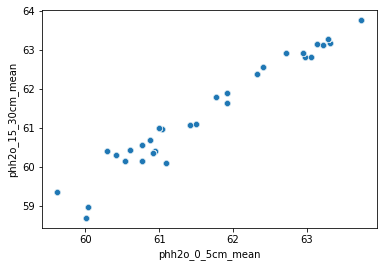

In [96]:
sns.scatterplot(data=nuts, x="phh2o_0_5cm_mean", y="phh2o_15_30cm_mean")

<AxesSubplot:xlabel='gr_female_household', ylabel='Count'>

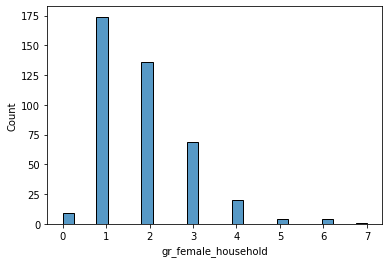

In [81]:
sns.histplot(nuts["gr_female_household"])

In [82]:
soy.to_csv("../../data/clean_survey_data/2019_soy.csv", index=False)
nuts.to_csv("../../data/clean_survey_data/2019_groundnuts.csv", index=False)

<AxesSubplot:xlabel='so_land_prod', ylabel='Count'>

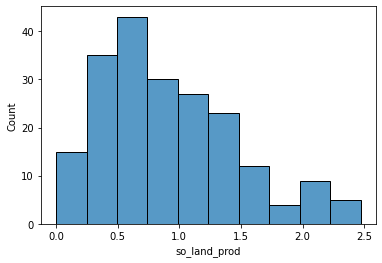

In [83]:
sns.histplot(soy["so_land_prod"])

<AxesSubplot:xlabel='gr_land_prod', ylabel='Count'>

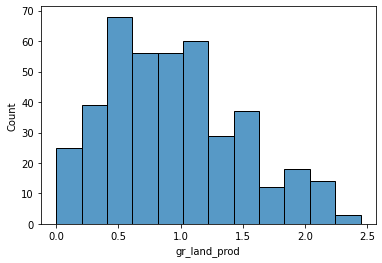

In [84]:
sns.histplot(nuts["gr_land_prod"])

In [85]:
# correlation 
corrmat = soy.corr()
print(corrmat["so_land_prod"].sort_values(ascending=False)[1:30,])
print(corrmat["so_land_prod"].sort_values(ascending=True)[1:30,])

so_vol                          0.376499
food_none                       0.195618
so_female_household             0.171844
so_male_household               0.171844
radio_dev_other                 0.169886
so_female_hired                 0.163773
food_skip                       0.160209
so_male_hired                   0.149239
gps_lon                         0.148391
food_hungry                     0.146513
food_variation                  0.139903
so_female_hired_workdays        0.138582
food_nutri                      0.128615
so_female_household_workdays    0.113041
so_male_household_workdays      0.113041
livestock_chicken               0.107479
gps_lat                         0.103904
food_eatnone                    0.100028
so_pay_hired                    0.097804
train_hinder_97                 0.095498
radio_group_family              0.093182
livestock_pigeons               0.093068
so_herbicides                   0.091633
food_less                       0.091283
land_how_rented 

<AxesSubplot:xlabel='nitrogen_30-60cm_mean', ylabel='so_land_prod'>

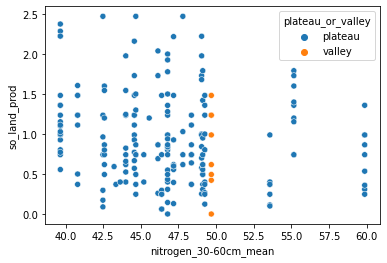

In [86]:
sns.scatterplot(data=soy, x="nitrogen_30-60cm_mean", y="so_land_prod", hue="plateau_or_valley")

<AxesSubplot:xlabel='so_female_household', ylabel='so_land_prod'>

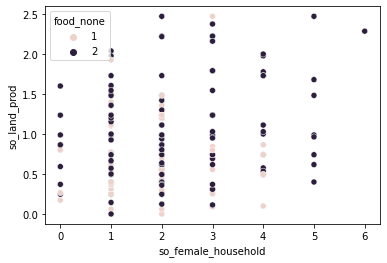

In [87]:
sns.scatterplot(data=soy, x="so_female_household", y="so_land_prod", hue="food_none")

<AxesSubplot:xlabel='so_prod_compare', ylabel='so_land_prod'>

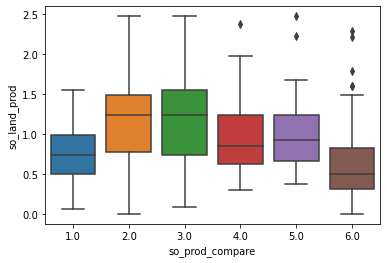

In [88]:
sns.boxplot(data=soy, x="so_prod_compare", y="so_land_prod")

In [89]:
# correlation 
corrmat = nuts.corr()
#print(corrmat["gr_land_prod"].sort_values(ascending=False)[1:30,])
#print(corrmat["gr_land_prod"].sort_values(ascending=True)[1:30,])
highest_corr = abs(corrmat["gr_land_prod"]).sort_values(ascending=False)[1:50].index.to_list()

<AxesSubplot:xlabel='train_frequency', ylabel='gr_land_prod'>

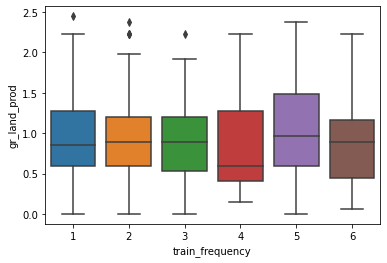

In [16]:
sns.boxplot(data=nuts, x="train_frequency", y="gr_land_prod")

In [19]:
nuts.groupby("radio").count()

id  date  groundnuts  soybeans  radio_comaco  gr_chemical  gr_manure  \
radio                                                                          
0      222   222         222       222           222          222        222   
1      195   195         195       195           195          195        195   

       gr_insecticides  gr_herbicides  gr_fungicides  land_how_purchased  \
radio                                                                      
0                  222            222            222                 222   
1                  195            195            195                 195   

       land_how_rented  land_how_inherited  land_how_received  \
radio                                                           
0                  222                 222                222   
1                  195                 195                195   

       land_how_acquired  nr_field  radio_dev_phone  radio_dev_smartphone  \
radio                                                                       
0                    222       222              222                   222   
1                    195       195              195                   195   

       radio_dev_tablet  radio_dev_radio  radio_dev_other  radio_dev_none  \
radio                                                                       
0                   222              222              222             222   
1                   195              195              195             195   

       radio_time  radio_group_family  radio_group_neighbor  \
radio                                                         
0             222                 222                   222   
1             195                 195                   195   

       radio_group_producer  radio_group_cooperative  radio_group_other  \
radio                                                                     
0                       222                      222                222   
1                       195                      195                195   

       train_frequency  train_hinder_1  train_hinder_9  train_hinder_2  \
radio                                                                    
0                  222             222             222             222   
1                  195             195             195             195   

       train_hinder_3  train_hinder_4  train_hinder_5  train_hinder_6  \
radio                                                                   
0                 222             222             222             222   
1                 195             195             195             195   

       train_hinder_7  train_hinder_8  train_hinder_97  gr_prod_compare  \
radio                                                                     
0                 222             222              222              222   
1                 195             195              195              195   

       gr_prod_compare_rainfall_excess  gr_prod_compare_rainfall_shortage  \
radio                                                                       
0                                  222                                222   
1                                  195                                195   

       gr_prod_compare_rainfall_pattern  gr_prod_compare_lack_fertilizer  \
radio                                                                      
0                                   222                              222   
1                                   195                              195   

       gr_prod_compare_lack_seeds  gr_prod_compare_soil_degradation  \
radio                                                                 
0                             222                               222   
1                             195                               195   

       gr_prod_compare_destruction_animals  gr_prod_compare_disease  \
radio                                                                 
0                

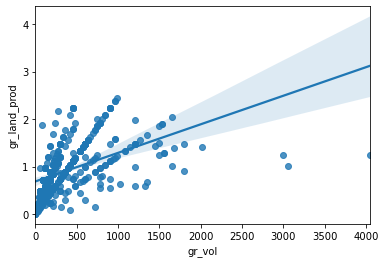

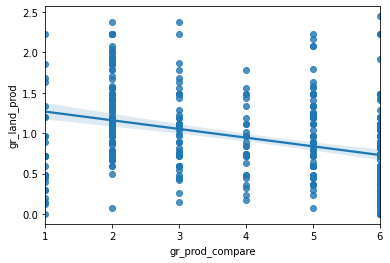

KeyError: 'ocd_100_200cm_mean'

In [90]:
for col in highest_corr:
    if (nuts_types.loc[col]["binary"] == 1):
        sns.boxplot(data=nuts, x=col, y="gr_land_prod")
        plt.show()
    else:
        sns.regplot(data=nuts, x=col, y="gr_land_prod")#, hue="plateau_or_valley")
        plt.show()

In [ ]:
sns.boxplot(data=nuts, x="gr_prod_compare", y="gr_land_prod")

In [11]:
nuts.groupby("food_nutri").count()

id  date  groundnuts  soybeans  radio_comaco  gr_chemical  \
food_nutri                                                               
1           209   209         209       209           209          209   
2           208   208         208       208           208          208   

            gr_manure  gr_insecticides  gr_herbicides  gr_fungicides  \
food_nutri                                                             
1                 209              209            209            209   
2                 208              208            208            208   

            land_how_purchased  land_how_rented  land_how_inherited  \
food_nutri                                                            
1                          209              209                 209   
2                          208              208                 208   

            land_how_received  land_how_acquired  nr_field  radio_dev_phone  \
food_nutri                                                                    
1                         209                209       209              209   
2                         208                208       208              208   

            radio_dev_smartphone  radio_dev_tablet  radio_dev_radio  \
food_nutri                                                            
1                            209               209              209   
2                            208               208              208   

            radio_dev_other  radio_dev_none  radio_time  radio_group_family  \
food_nutri                                                                    
1                       209             209         209                 209   
2                       208             208         208                 208   

            radio_group_neighbor  radio_group_producer  \
food_nutri                                               
1                            209                   209   
2                            208                   208   

            radio_group_cooperative  radio_group_other  train_frequency  \
food_nutri                                                                
1                               209                209              209   
2                               208                208              208   

            train_hinder_1  train_hinder_9  train_hinder_2  train_hinder_3  \
food_nutri                                                                   
1                      209             209             209             209   
2                      208             208             208             208   

            train_hinder_4  train_hinder_5  train_hinder_6  train_hinder_7  \
food_nutri                                                                   
1                      209             209             209             209   
2                      208             208             208             208   

            train_hinder_8  train_hinder_97  gr_prod_compare  \
food_nutri                                                     
1                      209              209              209   
2                      208              208              208   

            gr_prod_compare_rainfall_excess  \
food_nutri                                    
1                                       209   
2                                       208   

            gr_prod_compare_rainfall_shortage  \
food_nutri                                      
1                                         209   
2                                         208   

            gr_prod_compare_rainfall_pattern  gr_prod_compare_lack_fertilizer  \
food_nutri                                                                      
1                                        209                              209   
2                                        208                              208   

            gr_prod_compare_lack_seeds  gr_prod_compare_soil_degradation  \
food_nutri         

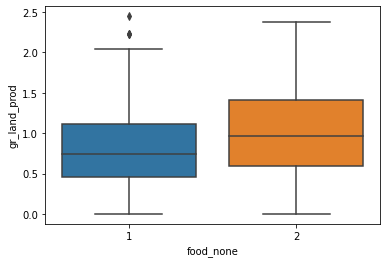

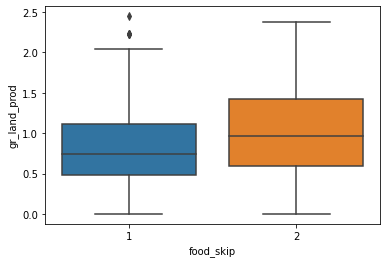

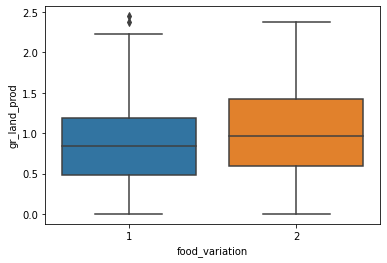

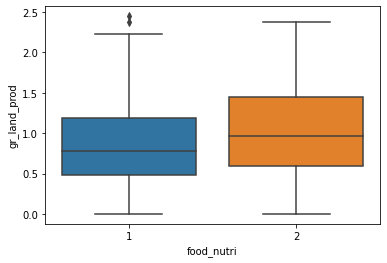

In [8]:
for col in ["food_none", "food_skip", "food_variation", "food_nutri"]:
    sns.boxplot(data=nuts, x=col, y="gr_land_prod")
    plt.show()

<AxesSubplot:xlabel='gr_female_household', ylabel='gr_land_prod'>

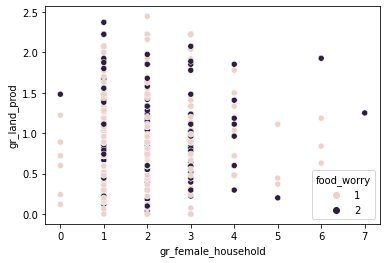

In [14]:
sns.scatterplot(data=nuts, x="gr_female_household", y="gr_land_prod", hue="food_worry")

In [ ]:
sns.scatterplot(data=nuts, x="gps_alt", y="gr_land_prod", hue="plateau_or_valley")

## Model Training for Groundnuts

In [ ]:
X_groundnuts = pd.get_dummies(nuts.drop(["gr_prod_compare", "gr_prod_compare_rainfall_excess",
                                         "gr_prod_compare_rainfall_shortage", "gr_prod_compare_rainfall_pattern",
                                         "gr_prod_compare_lack_fertilizer", "gr_prod_compare_lack_seeds",
                                         "gr_prod_compare_soil_degradation", "gr_prod_compare_destruction_animals",
                                         "gr_prod_compare_disease", "gr_prod_compare_labor_unavailable_family",
                                         "gr_prod_compare_labor_unavailable_hired", "gr_prod_compare_other",
                                         "gr_prod_compare_unknown", "groundnuts", "gr_land_prod", "gr_vol",
                                         "gr_area",
                                         "id", "date"], axis=1))
Y_groundnuts = nuts["gr_land_prod"]

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_groundnuts, Y_groundnuts, test_size=0.2, random_state=4)

In [92]:
reg = LinearRegression().fit(X_train, y_train)
print('The R-squared is: ', reg.score(X_train, y_train))

The R-squared is:  0.4644703456324847


In [93]:
X_constant = sm.add_constant(X_train) # adding a column of ones -> intercept
lin_reg = sm.OLS(y_train,X_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           gr_land_prod   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     1.729
Date:                Mon, 09 Nov 2020   Prob (F-statistic):           0.000309
Time:                        22:28:43   Log-Likelihood:                -165.54
No. Observations:                 333   AIC:                             555.1
Df Residuals:                     221   BIC:                             981.6
Df Model:                         111                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
soybeans                          -0.1194      0.101     -1.181      0.239      -0.319       0.080
radio_comaco                       0.2097      0.204      1.026      0.306      -0.193       0.613
gr_chemical                       -0.1093      0.593     -0.184      0.854      -1.278       1.059
gr_manure                         -0.0101      0.143     -0.071      0.944      -0.292       0.271
gr_insecticides                    0.2440      0.329      0.741      0.460      -0.405       0.893
gr_herbicides                     -0.2606      0.251     -1.040      0.299      -0.754       0.233
gr_fungicides                  -1.498e-13   3.26e-13     -0.459      0.647   -7.93e-13    4.93e-13
land_how_purchased                 0.2071      0.358      0.579      0.563      -0.498       0.912
land_how_rented                    0.0281      0.152      0.185      0.853      -0.271       0.327
land_how_inherited                 0.3126      0.182      1.718      0.087      -0.046       0.671
land_how_received                  0.2448      0.204      1.202      0.231      -0.157       0.646
land_how_acquired                  0.4270      0.208      2.053      0.041       0.017       0.837
nr_field                           0.0299      0.038      0.780      0.437      -0.046       0.105
radio_dev_phone                   -0.1198      0.090     -1.325      0.186      -0.298       0.058
radio_dev_smartphone               0.0412      0.151      0.273      0.785      -0.257       0.339
radio_dev_tablet                5.918e-13   6.56e-13      0.902      0.368   -7.01e-13    1.88e-12
radio_dev_radio                   -0.1152      0.050     -2.296      0.023      -0.214      -0.016
radio_dev_other                    0.6736      0.817      0.825      0.410      -0.936       2.284
radio_dev_none                     0.2807      0.557      0.504      0.615      -0.817       1.378
radio_time                        -0.0298      0.054     -0.547      0.585      -0.137       0.077
radio_group_family                -0.0789      0.182     -0.433      0.666      -0.438       0.281
radio_group_neighbor              -0.1040      0.190     -0.547      0.585      -0.479       0.271
radio_group_producer              -0.2687      0.151     -1.774      0.077      -0.567       0.030
radio_group_cooperative           -0.5752      0.234     -2.455      0.015      -1.037      -0.114
radio_group_other                 -0.1679      0.226     -0.742      0.459      -0.614       0.278
train_frequency                    0.0263      0.026      1.021      0.309      -0.025       0.077
train_hinder_1                    -0.0104      0.086     -0.121      0.903      -0.179       0.158
train_hinder_9                    -0.1353      0.147     -0.919      0.359      -0.426       0.155
train_hinder_2

In [23]:
# evaluate performance
def evaluate(y_test, y_pred):
    print(f"Explained Variance Score: {metrics.explained_variance_score(y_test, y_pred)}")
    print(f"Mean Absolute Error: {metrics.mean_absolute_error(y_test, y_pred)}")
    print(f"Mean Squared Error: {metrics.mean_squared_error(y_test, y_pred)}")
    print(f"Root Mean Squared Error: {metrics.mean_squared_error(y_test, y_pred, squared=False)}")

In [24]:
# fit the model
forest_model = RandomForestRegressor(random_state=1, n_estimators=100)
forest_model.fit(X_train,y_train)
# predict values for test set
y_pred = forest_model.predict(X_test)
# evaluate performance
evaluate(y_test, y_pred)
#feature importances
importances = forest_model.feature_importances_
indices = np.argsort(importances)[::-1]

Explained Variance Score: 0.12805128461649773
Mean Absolute Error: 0.37121041925694875
Mean Squared Error: 0.21981165370301928
Root Mean Squared Error: 0.4688407551642874


Feature ranking:
1. feature 72 (0.068256)
soybeans
2. feature 80 (0.049019)
radio_comaco
3. feature 83 (0.048475)
gr_chemical
4. feature 78 (0.047098)
gr_manure
5. feature 82 (0.045832)
gr_insecticides
6. feature 99 (0.029736)
gr_herbicides
7. feature 12 (0.027068)
gr_fungicides
8. feature 84 (0.026052)
land_how_purchased
9. feature 63 (0.024365)
land_how_rented
10. feature 85 (0.021260)
land_how_inherited
11. feature 119 (0.019667)
land_how_received
12. feature 106 (0.016471)
land_how_acquired
13. feature 25 (0.015699)
nr_field
14. feature 19 (0.015152)
radio_dev_phone
15. feature 91 (0.015074)
radio_dev_smartphone
16. feature 90 (0.012684)
radio_dev_tablet
17. feature 81 (0.012221)
radio_dev_radio
18. feature 121 (0.011929)
radio_dev_other
19. feature 53 (0.011633)
radio_dev_none
20. feature 145 (0.010806)
radio_time
21. feature 126 (0.009363)
radio_group_family
22. feature 133 (0.009205)
radio_group_neighbor
23. feature 116 (0.009133)
radio_group_producer
24. feature 123 (0.008892)


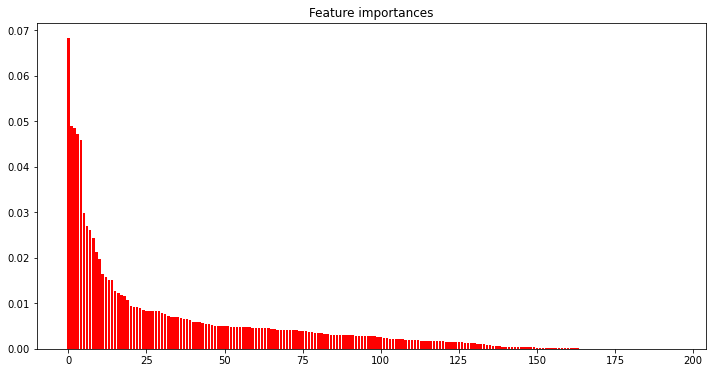

In [26]:
# Print the feature ranking
print("Feature ranking:")

for f in range(X_test.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print(X_test.columns[f])
# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(12,6))
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices],
        color="r", align="center")
plt.show()

In [315]:
# XGBoost
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.05,
                max_depth = 3, n_estimators = 100)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
evaluate(y_test, preds)

Explained Variance Score: 0.34987079348727
Mean Absolute Error: 0.3162965123949732
Mean Squared Error: 0.1649913959516357
Root Mean Squared Error: 0.40619132924231127


<AxesSubplot:xlabel='gr_land_prod'>

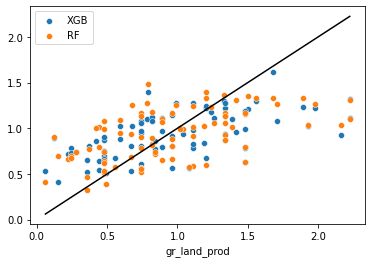

In [316]:
sns.scatterplot(x=y_test, y=preds, label="XGB")
sns.scatterplot(x=y_test, y=y_pred, label="RF")
sns.lineplot(x=[min(y_test), max(y_test)], y=[min(y_test), max(y_test)], color="black")

In [317]:
np.mean(abs(Y_groundnuts - np.mean(Y_groundnuts))**2) 

0.2868160871978265